In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/preprocessed-snake-images/preprocessed-cleaned-set/train/class-4/6aabc41571685772272b12bbc5fcdd64.jpg
/kaggle/input/preprocessed-snake-images/preprocessed-cleaned-set/train/class-4/ea5917771ec3e717eae961f0f1b1cad0.jpg
/kaggle/input/preprocessed-snake-images/preprocessed-cleaned-set/train/class-4/6ad5abeee40492d5bff1a102b0f47e66.jpg
/kaggle/input/preprocessed-snake-images/preprocessed-cleaned-set/train/class-4/aa899bd84902e64c33d1a45030ae5c9e.jpg
/kaggle/input/preprocessed-snake-images/preprocessed-cleaned-set/train/class-4/0cd252c938f2a09ae845a4d73f2f0508.jpg
/kaggle/input/preprocessed-snake-images/preprocessed-cleaned-set/train/class-4/7057a25e6a6ee33c6d8f81dd507bea7c.jpg
/kaggle/input/preprocessed-snake-images/preprocessed-cleaned-set/train/class-4/a36aaacc268d552c4c650a8579b0669a.jpg
/kaggle/input/preprocessed-snake-images/preprocessed-cleaned-set/train/class-4/b689c7813074f2929c78153d82d96ed6.jpg
/kaggle/input/preprocessed-snake-images/preprocessed-cleaned-set/train/c

In [2]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.multiclass import unique_labels

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')
    plt.xticks(rotation=45)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()


In [4]:
# Function to show sample images
def show_sample_images(dataX, dataY, class_names):
    num_classes = len(class_names)
    for i in range(num_classes):
        class_indices = np.where(dataY == i)[0]
        sample_indices = random.sample(list(class_indices), 5)
        plt.figure(figsize=(15, 3))
        for j, idx in enumerate(sample_indices):
            plt.subplot(1, 5, j + 1)
            plt.imshow(dataX[idx])
            plt.title(class_names[i])
            plt.axis('off')
        plt.show()


In [5]:
# Replace the path with your dataset path
data_dir = '../input/preprocessed-snake-images/preprocessed-cleaned-set/train/'
class_names = os.listdir(data_dir)

dataX = []
dataY = []

for class_name in class_names:
    class_path = os.path.join(data_dir, class_name)
    for image_name in tqdm(os.listdir(class_path)):
        image_path = os.path.join(class_path, image_name)
        image = cv2.imread(image_path)
        if type(image) == np.ndarray:
            image = cv2.resize(image, dsize=(224, 224))
            dataX.append(image)
            dataY.append(class_name)

# Convert labels to numeric form
label_mapping = {class_name: i for i, class_name in enumerate(class_names)}
dataY = np.array([label_mapping[label] for label in dataY])

m = len(dataX)
M = list(range(m))
random.seed(2021)
random.shuffle(M)

dataX = np.array(dataX)
dataY = np.array(dataY)

trainX = dataX[M[0:(m//4)*3]]
trainY = dataY[M[0:(m//4)*3]]

testX = dataX[M[(m//4)*3:]]
testY = dataY[M[(m//4)*3:]]

trainx, testx, trainy, testy = train_test_split(trainX, trainY, test_size=0.2, random_state=44)


100%|██████████| 3547/3547 [00:24<00:00, 143.68it/s]


In [6]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [7]:
# Use Xception as the base model with fine-tuning
base_model = Xception(include_top=False, input_shape=(224, 224, 3))

# Fine-tune more layers
for layer in base_model.layers[:-20]:  # Fine-tune more layers
    layer.trainable = True

# Modify the Dense layers with L2 regularization and Batch Normalization
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

# Use a learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=10000,
    decay_rate=0.9)

# Adjust the learning rate with the schedule
model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=35, restore_best_weights=True)


83683744/83683744 [==============================] - 3s 0us/step


In [8]:
# Increase the number of epochs
his = model.fit(datagen.flow(trainx, trainy, batch_size=32), validation_data=(testx, testy), epochs=350, callbacks=[early_stopping])

Epoch 1/350
326/326 [==============================] - 172s 417ms/step - loss: 11.9263 - accuracy: 0.5441 - val_loss: 10.3673 - val_accuracy: 0.7988
Epoch 2/350
326/326 [==============================] - 136s 415ms/step - loss: 9.4610 - accuracy: 0.7812 - val_loss: 8.2557 - val_accuracy: 0.8494
Epoch 3/350
326/326 [==============================] - 136s 418ms/step - loss: 7.3688 - accuracy: 0.8372 - val_loss: 6.4386 - val_accuracy: 0.8317
Epoch 4/350
326/326 [==============================] - 135s 413ms/step - loss: 5.5476 - accuracy: 0.8746 - val_loss: 4.7427 - val_accuracy: 0.8827
Epoch 5/350
326/326 [==============================] - 135s 413ms/step - loss: 4.0737 - accuracy: 0.8908 - val_loss: 3.4800 - val_accuracy: 0.8900
Epoch 6/350
326/326 [==============================] - 136s 415ms/step - loss: 2.9364 - accuracy: 0.9104 - val_loss: 2.6548 - val_accuracy: 0.8532
Epoch 7/350
326/326 [==============================] - 135s 413ms/step - loss: 2.1136 - accuracy: 0.9235 - val_loss:

In [9]:
# Evaluate the model
y_pred = model.predict(testx)
pred = np.argmax(y_pred, axis=1)

print(classification_report(testy, pred))
accuracy = accuracy_score(testy, pred)
print("Accuracy:", accuracy)

82/82 [==============================] - 6s 68ms/step
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       509
           1       0.97      0.96      0.96       590
           2       0.91      0.94      0.92       528
           3       0.88      0.88      0.88       471
           4       0.96      0.94      0.95       511

    accuracy                           0.92      2609
   macro avg       0.92      0.92      0.92      2609
weighted avg       0.92      0.92      0.92      2609

Accuracy: 0.9202759678037562


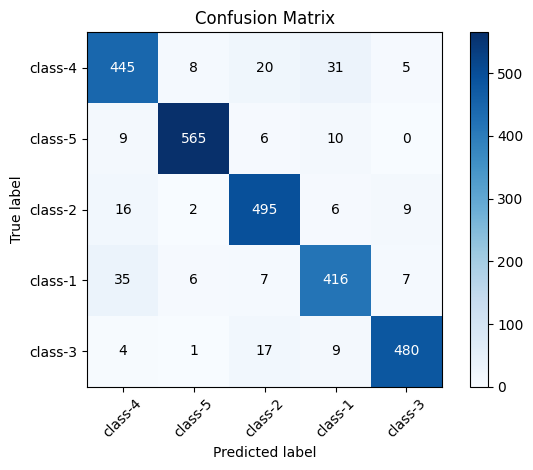

In [10]:
# Confusion Matrix
plot_confusion_matrix(testy, pred, class_names)


<Figure size 640x480 with 0 Axes>

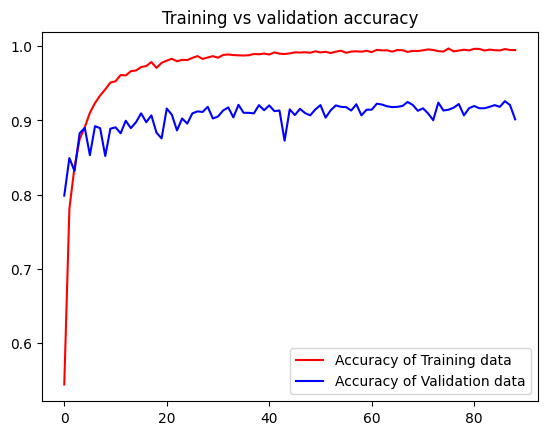

<Figure size 640x480 with 0 Axes>

In [11]:
# Plot training and validation accuracy
epochs = range(len(his.history['accuracy']))
plt.plot(epochs, his.history['accuracy'], 'r', label='Accuracy of Training data')
plt.plot(epochs, his.history['val_accuracy'], 'b', label='Accuracy of Validation data')
plt.title('Training vs validation accuracy')
plt.legend(loc=0)
plt.figure()

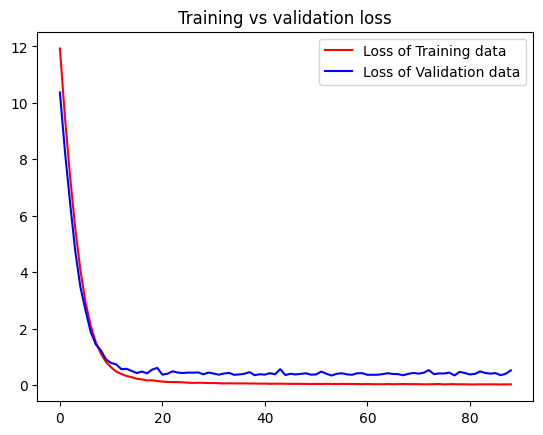

<Figure size 640x480 with 0 Axes>

In [12]:
# Plot training and validation loss
epochs = range(len(his.history['loss']))
plt.plot(epochs, his.history['loss'], 'r', label='Loss of Training data')
plt.plot(epochs, his.history['val_loss'], 'b', label='Loss of Validation data')
plt.title('Training vs validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()